<a href="https://colab.research.google.com/github/doantrang2312/London-housing-market/blob/main/FinalProject_TrangTruong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London Housing Market : Behind the Price Tag.

### Affordable Housing and Social Inequality in London

# Import libraries

First let's mount the google collab file to google drive so it can access the dataset, implement pandas, matplotlib, scikitlearn and other relevant libraries

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

In [ ]:
# dataviz
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

In [ ]:
# machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

In [ ]:
# Install geopandas library to work with geospatial data
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.2 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
from geopandas import GeoDataFrame

# Initial setup

In [ ]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_row', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Let's set up some formatter functions and the color scheme that will be used later on in the dataviz part

In [ ]:
# define a 'thousand' formatter function
def thousand_formatter(x, pos):
    """
    Formats y-axis tick labels in thousands.
    """
    return '{:.0f}K'.format(x/1000)

# define a 'million' formatter function
def million_formatter(x, pos):
    """
    Formats y-axis tick labels in millions.
    """
    return '{:.1f}m'.format(x/1000000)

# define a 'percentage' formatter function
def percentage_formatter(x, pos):
    """
    Formats y-axis tick labels in millions.
    """
    return '{:.1f}%'.format(x)

In [ ]:
# colors
light_grey = '#3e403e'
dark_grey = '#212421'
increase_color = 'green'
decrease_color = 'red'

In [ ]:
# define colors for richest and poorest areas
richest_color = plt.cm.Blues(0.7)
poorest_color = plt.cm.Oranges(0.7)

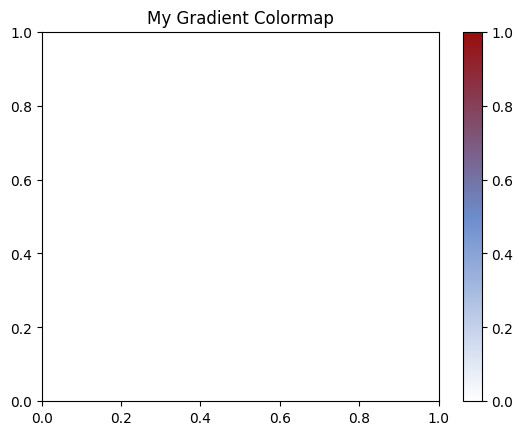

In [ ]:
# define the base color
# base_color = '#ff5a5f'
base_color = '#6b8ccc'

# define the colors for the colormap
colors = [(1, 1, 1), mcolors.hex2color(base_color), (0.6, 0.05, 0.05)]
# colors = [(0.7, 0.7, 0.7), mcolors.hex2color(base_color), (0, 0, 0)]

# create the colormap
cmap_name = 'my_cmap'
my_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# plot a colorbar to show the colormap
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(cmap=my_cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax)
ax.set_title('My Gradient Colormap')
plt.show()

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()


# Data is collected from 
### London Data Store  https://data.london.gov.uk/
### Bank of England   https://www.bankofengland.co.uk/

# Data collection - Geodata

Read geojson file that contains geo information of all the London boroughs. This will be used to plot the London map later 

In [ ]:
geo = gpd.read_file('/content/drive/MyDrive/Data Science/Final Project/neighbourhoods.geojson')


# Data collection - Average Price, Sales Volume and Index

Read the googlesheet file about England and London month average price, sales volume and house price index

In [ ]:
# Define worksheets 'Average price' and convert to a dataframe
price_ws = gc.open('UK House price index').worksheet('Average price').get_all_values()
price = pd.DataFrame(price_ws)
price.iloc[0,0] = 'period'
new_header = price.iloc[0] #grab the first row for the header
price = price[1:] #take the data less the header row
price.columns = new_header #set the header row as the df header
price = price[price.period != '']
price = price.melt(id_vars='period',var_name='area', value_name='average_price')


# # Define worksheets 'Sales Volume' and convert to a dataframe
volume_ws = gc.open('UK House price index').worksheet('Sales Volume').get_all_values()
volume = pd.DataFrame(volume_ws)
volume.iloc[0,0] = 'period'
new_header = volume.iloc[0] #grab the first row for the header
volume = volume[2:] #take the data less the header row
volume.columns = new_header #set the header row as the df header
volume = volume[volume.period != '']
volume = volume.melt(id_vars='period',var_name='area', value_name='volume')

# # Define worksheets 'Sales Volume' and convert to a dataframe
index_ws = gc.open('UK House price index').worksheet('Index Price').get_all_values()
index = pd.DataFrame(index_ws)
index.iloc[0,0] = 'period'
new_header = index.iloc[0] #grab the first row for the header
index = index[2:] #take the data less the header row
index.columns = new_header #set the header row as the df header
index = index[index.period != '']
index = index.melt(id_vars='period',var_name='area', value_name='house_index')

Merge the 3 dataframes into a single one and Apply some cleaning and transformation on the data

In [ ]:
# merge 3 df into one
merged_df = price.merge(volume, on = ['period','area']).merge(index, on = ['period','area'])

In [ ]:
merged_df['period'] = merged_df['period'].apply(lambda x : datetime.strptime(x,'%b-%y'))

In [ ]:
merged_df['period'] = pd.to_datetime(merged_df['period'])

In [ ]:
# update some boroughs names
area_dict = {'Barking & Dagenham': 'Barking and Dagenham', 'Hammersmith & Fulham': 'Hammersmith and Fulham', 'Kensington & Chelsea': 'Kensington and Chelsea','LONDON':'London'}
merged_df = merged_df.replace({"area": area_dict})

In [ ]:
merged_df = merged_df[merged_df.area != '']

In [ ]:
# convert to numeric
merged_df['average_price'] = merged_df.average_price.str.replace(',', '').astype(float)
merged_df['volume'] = merged_df.volume.str.replace(',', '').astype(float)
merged_df['house_index'] = merged_df.house_index.str.replace(',', '').astype(float)

In [ ]:
merged_df['year'] = merged_df.period.dt.year.astype(str)

In [ ]:
merged_df['month'] = merged_df.period.dt.month.astype(str)

In [ ]:
# define a list of London boroughs
london_list = ['period','City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
       'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
       'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth',
       'Westminster']

Separate the merged dataframe into 2 dataframes, one for London boroughs and one for England regions

In [ ]:
# Split the df into 2 dfs, one for London and the other for the grouped regions
london = merged_df[merged_df.area.isin(london_list)]
regions = merged_df[-merged_df.area.isin(london_list)]

The house price dataframe has monthly data whereas the other have yearly data.
We can calculate the yearly average price from the house price dataframe ('london') and merge all the yearly dataframes into one single dataframe

In [ ]:
# convert monthly to yearly data
london_price = london.groupby(['year','area']).agg({'average_price':'mean','volume':'sum','house_index':'mean'}).reset_index()
regions_price = regions.groupby(['year','area']).agg({'average_price':'mean','volume':'sum','house_index':'mean'}).reset_index()

In [ ]:
# convert to monthly data without the years
london_monthly_price = london.groupby(['month','area']).agg({'average_price':'mean','volume':'sum','house_index':'mean'}).reset_index()
regions_monthly_price = regions.groupby(['month','area']).agg({'average_price':'mean','volume':'sum','house_index':'mean'}).reset_index()

# Data collection - Total earnings, Male & Female earnings

Read the yearly 'earnings', 'male earnings' and 'female earnings' googlesheet dataframe and apply data wrangling

In [ ]:
# Total Weekly earnings
earnings_ws = gc.open('earnings-residence-borough').worksheet('Total, weekly').get_all_values()
earnings = pd.DataFrame(earnings_ws)
new_header = earnings.iloc[0] #grab the first row for the header
earnings= earnings[3:] #take the data less the header row
earnings.columns = new_header #set the header row as the df header

# Male Weekly earnings
male_earnings_ws = gc.open('earnings-residence-borough').worksheet('Male, Weekly').get_all_values()
male_earnings = pd.DataFrame(male_earnings_ws)
male_earnings.iloc[0,1] = 'Area' # The name of the columns area in male_earnings df is missing, we need to add the column name
new_header = male_earnings.iloc[0] #grab the first row for the header
male_earnings= male_earnings[3:] #take the data less the header row
male_earnings.columns = new_header #set the header row as the df header

# Female Weekly earnings
female_earnings_ws = gc.open('earnings-residence-borough').worksheet('Female, Weekly').get_all_values()
female_earnings = pd.DataFrame(female_earnings_ws)
new_header = female_earnings.iloc[0] #grab the first row for the header
female_earnings= female_earnings[3:] #take the data less the header row
female_earnings.columns = new_header #set the header row as the df header

Data wrangling on the earnings dataframes

In [ ]:
# Remove columns 'conf %' as we don't need them
earnings = earnings.drop("",axis=1)
male_earnings = male_earnings.drop("",axis=1)
female_earnings = female_earnings.drop("",axis=1)

In [ ]:
# Remove columns 'Code' as we don't need the Area code
earnings.drop(columns = 'Code', inplace = True)
male_earnings.drop(columns = 'Code', inplace = True)
female_earnings.drop(columns = 'Code', inplace = True)

Convert the dataframes into the long and homogeous format which contains 3 columns 'year', 'area' and 'earnings'. This will be concatenated with other dataframes with different features

In [ ]:
# Convert wide to long format
earnings = earnings.melt(id_vars=['Area'],var_name='year', value_name='earnings')
male_earnings = male_earnings.melt(id_vars=['Area'],var_name='year', value_name='male_earnings')
female_earnings = female_earnings.melt(id_vars=['Area'],var_name='year', value_name='female_earnings')

In [ ]:
# Merge 3 earnings dataframe into one
earnings = earnings.merge(male_earnings, on = ['Area','year']).merge(female_earnings, on = ['Area','year'])

In [ ]:
earnings.rename(columns = {'Area':'area'},inplace = True)

In [ ]:
# Remove empty lines
earnings = earnings[earnings.area != '']

In [ ]:
# Update the name of some areas in order to have a same list of London boroughs
earnings = earnings.replace({"area": area_dict})

Split the merged dataframe about earnings into 2 separate dataframes, one for London boroughs and one for England regions

In [ ]:
# Split the df into 2 dfs, one for London and the other for the grouped regions
london_earnings = earnings[earnings.area.isin(london_list)]
regions_earnings = earnings[-earnings.area.isin(london_list)]

In [ ]:
# convert some columns to numeric
london_earnings['earnings'] = pd.to_numeric(london_earnings.earnings, errors='coerce')
london_earnings['male_earnings'] = pd.to_numeric(london_earnings.male_earnings, errors='coerce')
london_earnings['female_earnings'] = pd.to_numeric(london_earnings.female_earnings, errors='coerce')

<ipython-input-77-31cd38086833>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_earnings['earnings'] = pd.to_numeric(london_earnings.earnings, errors='coerce')
<ipython-input-77-31cd38086833>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_earnings['male_earnings'] = pd.to_numeric(london_earnings.male_earnings, errors='coerce')
<ipython-input-77-31cd38086833>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

# Data collection - Household Recycling per borough

Read the 'recycling' googlesheet file and Apply data wrangling

In [ ]:
recycling_ws = gc.open('household-recycling-borough').worksheet('Household Recycling Rates').get_all_values()
recycling = pd.DataFrame(recycling_ws)
new_header = recycling.iloc[0] #grab the first row for the header
recycling =recycling[2:] #take the data less the header row
recycling.columns = new_header #set the header row as the df header

In [ ]:
# Remove columns 'New Code' and 'Code'
recycling.drop(columns = ['New Code','Code'], inplace = True)

In [ ]:
recycling.rename(columns = {'Area':'area'},inplace = True)

In [ ]:
# Remove empty rows
recycling = recycling[recycling['area'] != '']

Transform the recycling dataframe from wide to long, following the homogeous format with 3 columns 'year', 'area' and 'recycling rate'

In [ ]:
# Convert wide to long format
recycling = recycling.melt(id_vars=['area'],var_name='year', value_name='recycling_rate')

In [ ]:
# Update the name of some areas in order to have a same list of London boroughs
recycling = recycling.replace({"area": area_dict})

In [ ]:
# Update column 'year'
recycling['year'] = recycling['year'].str[:4].astype(int) + 1
recycling['year'] = recycling['year'].astype(str)

In [ ]:
# Split the df into 2 dfs, one for London and the other for the grouped regions
london_recycling = recycling[recycling.area.isin(london_list)]
regions_recycling = recycling[-recycling.area.isin(london_list)]

In [ ]:
# convert to numeric
london_recycling['recycling_rate'] = pd.to_numeric(london_recycling.recycling_rate, errors = 'coerce')

<ipython-input-86-83b822378cbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_recycling['recycling_rate'] = pd.to_numeric(london_recycling.recycling_rate, errors = 'coerce')


# Data collection - Jobs numbers and density

Read the 'jobs' and 'jobs_density' googlesheet files and Apply data wrangling

In [ ]:
# Jobs number
jobs_ws = gc.open('jobs-and-job-density').worksheet('Jobs').get_all_values()
jobs = pd.DataFrame(jobs_ws)
new_header = jobs.iloc[0] #grab the first row for the header
jobs = jobs[2:] #take the data less the header row
jobs.columns = new_header #set the header row as the df header

# Jobs density
jobs_density_ws = gc.open('jobs-and-job-density').worksheet('Jobs Density').get_all_values()
jobs_density = pd.DataFrame(jobs_density_ws)
new_header = jobs_density.iloc[0] #grab the first row for the header
jobs_density = jobs_density[2:] #take the data less the header row
jobs_density.columns = new_header #set the header row as the df header

In [ ]:
# Remove column 'Code':
jobs.drop(columns = 'Code', inplace = True)
jobs_density.drop(columns = 'Code', inplace = True)

Convert jobs and jobs_density dataframe from wide to long format, which is the homogeous format with 3 colums 'year', 'area' and 'jobs'/'jobs_density'

In [ ]:
# Convert wide to long format
jobs = jobs.melt(id_vars=['Area'],var_name='year', value_name='jobs_number')
jobs_density = jobs_density.melt(id_vars=['Area'],var_name='year', value_name='jobs_density')

In [ ]:
# Merge dataframe jobs with dataframe jobs_density
jobs = jobs.merge(jobs_density, on = ['Area','year'])

In [ ]:
# update column name
jobs.rename(columns = {'Area':'area'},inplace = True)

In [ ]:
# Remove empty rows
jobs = jobs[jobs['area'] != '']

In [ ]:
# Update the name of some areas in order to have a same list of London boroughs
jobs = jobs.replace({"area": area_dict})

In [ ]:
# Split the df into 2 dfs, one for London and the other for the grouped regions
london_jobs = jobs[jobs.area.isin(london_list)]
regions_jobs = jobs[-jobs.area.isin(london_list)]

In [ ]:
# convert to numeric
london_jobs['jobs_number'] = london_jobs.jobs_number.str.replace(',','').astype(float)
london_jobs['jobs_density'] = pd.to_numeric(london_jobs.jobs_density, errors = 'coerce')

<ipython-input-95-f094136ff214>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_jobs['jobs_number'] = london_jobs.jobs_number.str.replace(',','').astype(float)
<ipython-input-95-f094136ff214>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_jobs['jobs_density'] = pd.to_numeric(london_jobs.jobs_density, errors = 'coerce')


# Data collection - Dwellings

Read the 'dwellings' googlesheet file and Apply data wrangling

In [ ]:
# Dwellings number
dwellings_ws = gc.open('Number_and_density_of_dwellings_by_borough').worksheet('Number of dwellings').get_all_values()
dwellings = pd.DataFrame(dwellings_ws)
new_header = dwellings.iloc[0] #grab the first row for the header
dwellings = dwellings[2:] #take the data less the header row
dwellings.columns = new_header #set the header row as the df header

# Dwellings density
dwellings_density_ws = gc.open('Number_and_density_of_dwellings_by_borough').worksheet('Dwellings per hectare').get_all_values()
dwellings_density = pd.DataFrame(dwellings_density_ws)
new_header = dwellings_density.iloc[0] #grab the first row for the header
dwellings_density = dwellings_density[2:] #take the data less the header row
dwellings_density.columns = new_header #set the header row as the df header

In [ ]:
# Remove column 'ONS code':
dwellings.drop(columns = 'ONS code', inplace = True)
dwellings_density.drop(columns = 'ONS code', inplace = True)

Convert the dwellings dataframes from wide to long, following the homogeous format with 3 columns 'year', 'area' and 'dwellings' or 'dwelings_density'

In [ ]:
# Convert wide to long format
dwellings = dwellings.melt(id_vars=['Area name'],var_name='year', value_name='dwellings_number')
dwellings_density = dwellings_density.melt(id_vars=['Area name', 'Total Area (Hectares)'],var_name='year', value_name='dwellings_density')

In [ ]:
# Merge 2 dataframes
dwellings = dwellings.merge(dwellings_density, on = ['Area name','year'])

In [ ]:
# Rename column name
# dwellings.rename(columns = {'Area name' : 'area'}, inplace = True)
dwellings.columns = ['area','year','dwellings_number','surface_in_ha','dwellings_density']

In [ ]:
# Remove empty rows
dwellings = dwellings[dwellings['area'] != '']

In [ ]:
# split into 2 df for London and Regions
london_dwellings = dwellings[dwellings.area.isin(london_list)]
regions_dwellings = dwellings[-dwellings.area.isin(london_list)]

In [ ]:
# convert to numeric
london_dwellings['dwellings_number'] = london_dwellings['dwellings_number'].str.replace(',','').astype(float)
london_dwellings['surface_in_ha'] = london_dwellings['surface_in_ha'].str.replace(',','').astype(float)
london_dwellings['dwellings_density'] = london_dwellings['dwellings_density'].astype(float)

<ipython-input-103-945c94e973d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_dwellings['dwellings_number'] = london_dwellings['dwellings_number'].str.replace(',','').astype(float)
<ipython-input-103-945c94e973d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_dwellings['surface_in_ha'] = london_dwellings['surface_in_ha'].str.replace(',','').astype(float)
<ipython-input-103-945c94e973d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

# Data collection - Population Age

Read the 'age' googlesheet file and Apply data wrangling

In [ ]:
# dataframe age
age_ws = gc.open('ons-mye-custom-age-tool-2020').worksheet('Single year of age').get_all_values()
age = pd.DataFrame(age_ws[3:], columns=age_ws[1:3])
age = age.iloc[:,1:]

Convert the age dataframe from wide to long, following the homogeous format with 3 columns 'year', 'area' and 'age'

In [ ]:
# convert from wide to long format and parsing
age = age.melt(id_vars=[('', 'Year'), ('', 'Borough')], var_name=['is_male', 'age'], value_name = 'population')
age = age.rename(columns={('', 'Year'): 'year', ('', 'Borough'): 'area'})
age = age[(age.age != 'No Males') & (age.age != 'No Females')]
age['is_male'] = age['is_male'].apply(lambda x : True if x == 'M' else False)
age = age.replace({"area": area_dict})

In [ ]:
# Split the df into 2 dfs, one for London and the other for the grouped regions
london_age = age[age.area.isin(london_list)]
regions_age = age[-age.area.isin(london_list)]

In [ ]:
# convert to numeric
london_age['age'] = london_age['age'].replace('90+','90').astype(int)
london_age['population'] = pd.to_numeric(london_age['population'].str.replace(',',''), errors = 'coerce')
london_age.population.fillna(0,inplace = True)

<ipython-input-107-e9443de9047a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_age['age'] = london_age['age'].replace('90+','90').astype(int)
<ipython-input-107-e9443de9047a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_age['population'] = pd.to_numeric(london_age['population'].str.replace(',',''), errors = 'coerce')
<ipython-input-107-e9443de9047a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

Caterogize the ages into 4 different age groups: Youth, Working-age adults, mid-career and senior. Each group can be split into 2 sub categories: male and female.

So there are 8 categories in total corresponding to 8 columns, the values in each column are the number of people in each age/sex group

In [ ]:
# define the bins and labels for age categories
bins = [-1, 20, 40, 66, 90]
labels = ['youth', 'working-age adults', 'mid-career', 'seniors']

# create the age category column
london_age['age_category'] = pd.cut(london_age['age'], bins=bins, labels=labels)

# groupby age_category instead of age
london_age = london_age.groupby(['year','area','age_category','is_male']).population.sum().reset_index()

<ipython-input-108-c77ae17000c7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_age['age_category'] = pd.cut(london_age['age'], bins=bins, labels=labels)


In [ ]:
# pivot the df
london_age = pd.pivot(london_age, index= ['year','area'] ,columns=['age_category','is_male'], values='population').reset_index()
london_age.columns = ['year','area','youth_male','youth_female','working_age_male','working_age_female','mid_career_male','mid_career_female','senior_male','senior_female']

In [ ]:
# create column total_population
london_age['total_population'] = london_age.select_dtypes(include=['number']).sum(axis=1)


# Data collection - Personal Wellbeing

Read the 'personal wellbeing' googlesheet file and Apply data wrangling

In [ ]:
# dataframe personal wellbeing
wb_ws = gc.open('personal-well-being-borough').worksheet('Summary - Mean Scores').get_all_values()
wb = pd.DataFrame(wb_ws[3:], columns=wb_ws[0:3])


In [ ]:
# remove empty columns and column 'Code'
wb = wb.dropna(axis=1, how='all')
wb = wb.iloc[:,1:]

In [ ]:
# update columns names
wb.rename(columns = {'Life Satisfaction':'life_satisfaction', 'Worthwhile':'worthwhile', 'Happiness':'happiness', 'Anxiety':'anxiety'},inplace = True)

Convert the wellbeing dataframe from wide to long, following the homogeous format with 3 columns 'year', 'area' and 'hapiness'/'anxiety'/'life_satisfaction'/'worthwhile'

In [ ]:
# convert from wide to long format and parsing
wb = wb.melt(id_vars=[('', 'Area')], var_name=['wb_type', 'year'], value_name = 'note')
wb = wb.rename(columns={('', 'Area'): 'area'})

<ipython-input-114-165b585cf02a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  wb = wb.melt(id_vars=[('', 'Area')], var_name=['wb_type', 'year'], value_name = 'note')


In [ ]:
# remove columns without meaningful data
wb = wb[wb.area != '']
wb = wb[wb.year!= '']

In [ ]:
# fill empty cells with forward filling method
wb.replace('', np.nan, inplace=True)
wb.fillna(method="ffill",inplace = True)

In [ ]:
# more parsing column 'area' and 'year'
wb['year'] = wb.year.str[:4].astype(int) + 1
wb['year'] = wb.year.astype(str)
wb = wb.replace({"area": area_dict})

In [ ]:
wb.wb_type.unique()

array(['life_satisfaction', 'worthwhile', 'happiness', 'anxiety'],
      dtype=object)

In [ ]:
# Split the df into 2 dfs, one for London and the other for the grouped regions
london_wb = wb[wb.area.isin(london_list)]
regions_wb = wb[-wb.area.isin(london_list)]

In [ ]:
# convert to numeric
london_wb['note'] = pd.to_numeric(london_wb.note, errors = 'coerce')

<ipython-input-120-cbfed73e2414>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_wb['note'] = pd.to_numeric(london_wb.note, errors = 'coerce')


In [ ]:
# pivot the df
london_wb = pd.pivot(london_wb, index= ['year','area'] ,columns='wb_type', values='note').reset_index()

# Data collection - Crime

Read the 'crime rate' googlesheet file and Apply data wrangling

In [ ]:
# dataframe crime
crime_ws = gc.open('MPS Borough Level Crime (Historical)').worksheet('MPS Borough Level Crime (Historical).csv').get_all_values()
crime = pd.DataFrame(crime_ws[1:], columns=crime_ws[0])

crime1_ws = gc.open('MPS Borough Level Crime (most recent 24 months)').worksheet('MPS Borough Level Crime (most recent 24 months).csv').get_all_values()
crime1 = pd.DataFrame(crime1_ws[1:], columns=crime1_ws[0])

In [ ]:
# convert from wide to long format and parsing
crime = crime.melt(id_vars=['MajorText','MinorText','LookUp_BoroughName'], var_name=['year_month'], value_name = 'crime_number')
crime = crime.rename(columns={'LookUp_BoroughName': 'area'})

crime1 = crime1.melt(id_vars=['MajorText','MinorText','LookUp_BoroughName'], var_name=['year_month'], value_name = 'crime_number')
crime1 = crime1.rename(columns={'LookUp_BoroughName': 'area'})

In [ ]:
# create new column
crime['year'] = crime.year_month.str[:4]
crime1['year'] = crime1.year_month.str[:4]

In [ ]:
# update dtype
crime['crime_number'] = crime.crime_number.astype(int)
crime1['crime_number'] = crime1.crime_number.astype(int)

In [ ]:
# concate 2 df
crime = pd.concat([crime,crime1])

In [ ]:
# calculate total number of crimes per borough per year
crime = crime.groupby(['year','area']).crime_number.sum().reset_index()

In [ ]:
# ignore year 2023 as not a full year
london_crime = crime[crime.year != '2023']

# Data collection - Interest rate

Read the 'interest rate' googlesheet file and Apply data wrangling

In [ ]:
# dataframe crime
ir_ws = gc.open('Bank Rate history and data  Bank of England Database').worksheet('Bank Rate history and data  Bank of England Database.csv').get_all_values()
ir = pd.DataFrame(ir_ws[1:],columns=ir_ws[0])


In [ ]:
# update columns names and datatype
ir['Rate'] = ir['Rate'].astype(float)
ir['Date Changed']=pd.to_datetime(ir['Date Changed'])
ir.rename(columns={'Date Changed':'date','Rate':'interest_rate'},inplace=True)

In [ ]:
# add column
ir['year'] = ir.date.dt.year

In [ ]:
# groupby year
ir = ir.groupby('year').interest_rate.mean().reset_index()
ir = ir[ir.year >= 1995]

# Insert Dict to the dataframe using DataFrame.append()
new_rows = {'year':[2002,2010,2011,2012,2013,2014,2015,2019], 'interest_rate':[4,0.5,0.5,0.5,0.5,0.5,0.5,0.75]}
new_rows_df = pd.DataFrame.from_dict(new_rows)

# add new rows in existing dataframe
ir = pd.concat([ir,new_rows_df])
ir = ir.sort_values('year')

In [ ]:
ir

,year,interest_rate
20,1995,6.50500
21,1996,5.92500
22,1997,6.75000
23,1998,6.93750
24,1999,5.41667
25,2000,5.87500
26,2001,4.96429
0,2002,4.00000
27,2003,3.66667
28,2004,4.37500


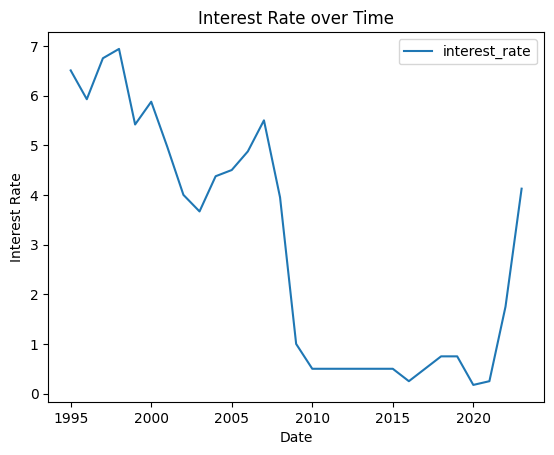

In [ ]:
ir.plot(x='year', y='interest_rate')
plt.title('Interest Rate over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.show()

# Dataset Overview

Let's take a look on all the dataframe we have imported and cleaned.
So far, we have:
- df 'london': monthly data about house price, sales volumes and house price index  per London borough
- df 'london_price': yearly data about house price, sales volumes and house price index  per London borough
- df 'london_earnings': yearly data about earnings per London borough
- df 'london_recycling': yearly data about recyling per London borough
- df 'london_jobs': yearly data about jobs and jobs density per London borough
- df 'london_dwellings': yearly data about dwellings and dwellings density per London borough
- df 'london_age': yearly data about population per age per London borough
- df 'london_wb': yearly data about personal wellbeing per London borough

In [ ]:
# merge into one dataframe
london_y = london_price.merge(london_earnings, on = ['year','area'], how = 'outer').merge(
                              london_recycling, on = ['year','area'], how = 'outer').merge(
                              london_jobs, on = ['year','area'], how = 'outer').merge(
                              london_dwellings, on = ['year','area'], how = 'outer').merge(
                              london_age, on = ['year','area'], how = 'outer').merge(
                              london_wb, on = ['year','area'], how = 'outer').merge(
                              london_crime, on = ['year','area'], how = 'left')

In [ ]:
london_y.year.unique()

array(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022'], dtype=object)

In [ ]:
london_y['year'] = london_y.year.astype(int)

In [ ]:
london_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 0 to 923
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                924 non-null    int64  
 1   area                924 non-null    object 
 2   average_price       924 non-null    float64
 3   volume              924 non-null    float64
 4   house_index         924 non-null    float64
 5   earnings            642 non-null    float64
 6   male_earnings       632 non-null    float64
 7   female_earnings     643 non-null    float64
 8   recycling_rate      758 non-null    float64
 9   jobs_number         726 non-null    float64
 10  jobs_density        726 non-null    float64
 11  dwellings_number    627 non-null    float64
 12  surface_in_ha       627 non-null    float64
 13  dwellings_density   627 non-null    float64
 14  youth_male          726 non-null    float64
 15  youth_female        726 non-null    float64
 16  working_

In [ ]:
inner = ['Camden','Greenwich','Hackney','Hammersmith and Fulham','Islington','Kensington and Chelsea','Lambeth','Lewisham','Southwark','Tower Hamlets','Wandsworth','Westminster','Newham', 'Harringey','City of London']
inner_y = london_y[london_y.area.isin(inner)]

In [ ]:
london_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 0 to 923
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                924 non-null    int64  
 1   area                924 non-null    object 
 2   average_price       924 non-null    float64
 3   volume              924 non-null    float64
 4   house_index         924 non-null    float64
 5   earnings            642 non-null    float64
 6   male_earnings       632 non-null    float64
 7   female_earnings     643 non-null    float64
 8   recycling_rate      758 non-null    float64
 9   jobs_number         726 non-null    float64
 10  jobs_density        726 non-null    float64
 11  dwellings_number    627 non-null    float64
 12  surface_in_ha       627 non-null    float64
 13  dwellings_density   627 non-null    float64
 14  youth_male          726 non-null    float64
 15  youth_female        726 non-null    float64
 16  working_

# EDA House price over time

Let's examine how the average housing price has evolved over time and how different economic, financial, social and even political events have impacted the average price series

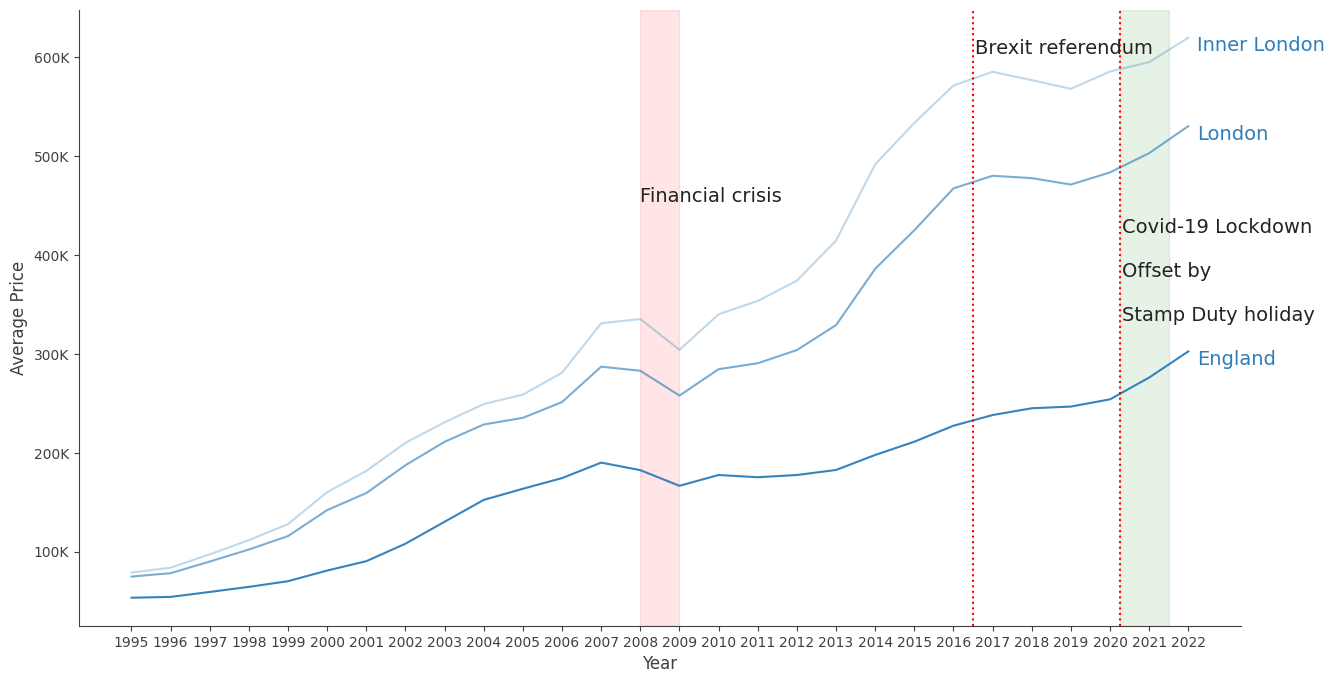

In [ ]:
# line chart for each borough over time
unique_areas = ['Inner London','London','England']

fig, ax = plt.subplots(figsize=(15,8))


# plot data
for i, area in enumerate(unique_areas):
    area_data = regions_price[regions_price['area']==area]
    alpha = i/3+0.3
    ax.plot(area_data['year'], area_data['average_price'], label=area, color=richest_color, alpha=alpha)


# add legend on lines
for line in ax.lines:
    label = line.get_label()
    ax.annotate(label, xy=(regions_price['year'].max(), line.get_ydata()[-1]-8000), xytext=(6,0), color=line.get_color(), textcoords="offset points", va="center", fontsize = 14)


# set title and axis label
# ax.set_title('Average Price over time', fontsize = 16)
ax.set_xlabel('Year', fontsize = 12, color = light_grey)
ax.set_ylabel('Average Price', fontsize = 12, color = light_grey)

# Set axis colors
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)
ax.spines[['right','top']].set_visible(False)


# create a dictionary with the ticks labels as keys and position as value
tick_labels = ax.get_xticklabels()
labels = [tick.get_text() for tick in tick_labels]
xtick_positions = [label.get_position()[0] for label in ax.get_xticklabels()]
label_pos_dict = dict(zip(labels, xtick_positions))

# Set tick colors
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# set formatter function to y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousand_formatter))

# Add events
ax.axvspan('2008','2009', alpha=0.1, color=decrease_color)
ax.text('2008', 450000, 'Financial crisis', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvline(x=label_pos_dict['2016'] + 0.5, color=decrease_color, linestyle=':')
ax.text(label_pos_dict['2016'] + 0.55, 600000, 'Brexit referendum', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvline(x=label_pos_dict['2020']+0.25, color=decrease_color, linestyle=':')
ax.axvspan(label_pos_dict['2020']+0.25,label_pos_dict['2021']+0.5, alpha=0.1, color=increase_color)
ax.text(label_pos_dict['2020'] + 0.3, 330000, 'Covid-19 Lockdown\n\nOffset by\n\nStamp Duty holiday', ha='left', va='bottom', fontsize=14, color=dark_grey)

plt.show()

Observations:
1995-2005 : steady increase

2005-2008 : greater increase

2008-2009 : downturn due to the financial crisis

2009-2016 : substantial recovery

2016-2019 : slight dip following Brexit referendum result

2019-2022 : upward trend in spite of Covid-19 pandemic


In [ ]:
regions_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           336 non-null    object 
 1   area           336 non-null    object 
 2   average_price  336 non-null    float64
 3   volume         336 non-null    float64
 4   house_index    336 non-null    float64
dtypes: float64(3), object(2)
memory usage: 13.2+ KB


In [ ]:
a = regions_price[(regions_price.area == 'England') & (regions_price.year == '1995')].average_price.values
b = regions_price[(regions_price.area == 'Inner London') & (regions_price.year == '1995')].average_price.values
print('England 1995: ' +  str(a))
print('Inner London 1995: ' +  str(b))
print('gap in 1995:' + str(b/a -1))

c= regions_price[(regions_price.area == 'England') & (regions_price.year == '2008')].average_price.values
d = regions_price[(regions_price.area == 'Inner London') & (regions_price.year == '2008')].average_price.values
print('England 2008: ' +  str(c))
print('Inner London 2006: ' +  str(d))
print('gap in 2006:' + str(d/c-1))

England 1995: [53322.41666667]
Inner London 1995: [78828.58333333]
gap in 1995:[0.47833853]
England 2008: [182379.91666667]
Inner London 2006: [335258.75]
gap in 2006:[0.83824379]


# EDA House Price vs Interest rate over time

Let's add the Interest rate series to see the relationship between Interest Rate and House price

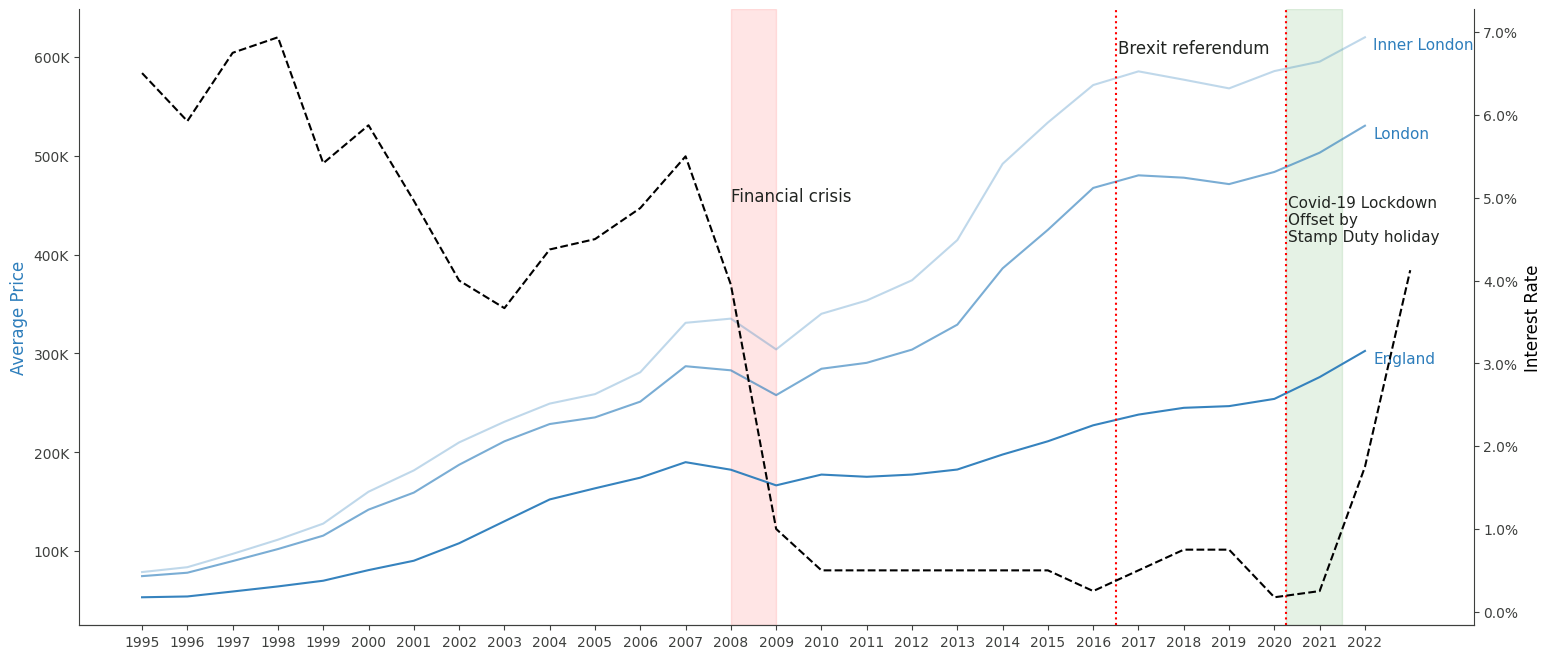

In [ ]:
# line chart for each borough over time
unique_areas = ['Inner London','London','England']

fig, ax = plt.subplots(figsize=(18,8))

# AVERAGE PRICE
# plot data
for i, area in enumerate(unique_areas):
    area_data = regions_price[regions_price['area']==area]
    alpha = i/3+0.3
    ax.plot(area_data['year'], area_data['average_price'], label=area, color=richest_color, alpha=alpha)

# add legend on lines
for line in ax.lines:
    label = line.get_label()
    ax.annotate(label, xy=(regions_price['year'].max(), line.get_ydata()[-1]-8000), xytext=(6,0), color=line.get_color(), textcoords="offset points", va="center", fontsize = 11)

# set title and axis label
# ax.set_title('Average Price & Interest Rate over time', fontsize = 16)
# ax.set_xlabel('Year', fontsize = 12, color = light_grey)
ax.set_ylabel('Average Price', fontsize = 12, color = richest_color)

# Set axis colors
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)
ax.spines[['right','top']].set_visible(False)


# create a dictionary with the ticks labels as keys and position as value
tick_labels = ax.get_xticklabels()
labels = [tick.get_text() for tick in tick_labels]
xtick_positions = [label.get_position()[0] for label in ax.get_xticklabels()]
label_pos_dict = dict(zip(labels, xtick_positions))

# Set tick colors
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# set formatter function to y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousand_formatter))

# Add events
ax.axvspan('2008','2009', alpha=0.1, color=decrease_color)
ax.text('2008', 450000, 'Financial crisis', ha='left', va='bottom', fontsize=12, color=dark_grey)
ax.axvline(x=label_pos_dict['2016'] + 0.5, color=decrease_color, linestyle=':')
ax.text(label_pos_dict['2016'] + 0.55, 600000, 'Brexit referendum', ha='left', va='bottom', fontsize=12, color=dark_grey)
ax.axvline(x=label_pos_dict['2020']+0.25, color=decrease_color, linestyle=':')
ax.axvspan(label_pos_dict['2020']+0.25,label_pos_dict['2021']+0.5, alpha=0.1, color=increase_color)
ax.text(label_pos_dict['2020'] + 0.3, 410000, 'Covid-19 Lockdown\nOffset by\nStamp Duty holiday', ha='left', va='bottom', fontsize=11, color=dark_grey)

# INTEREST RATE
# Plot the interest rate
x= ir['year']
x_pos = np.arange(len(x))
ax2 = ax.twinx()
ax2.plot(x_pos, ir.interest_rate, label='Interest Rate', color = 'black',linestyle='dashed')

# set axis label
ax2.set_ylabel('Interest Rate', fontsize = 12, color = 'black')
# Set tick colors
ax2.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax2.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# create a dictionary with the ticks labels as keys and position as value
tick_labels = ax2.get_xticklabels()
labels = [tick.get_text() for tick in tick_labels]
xtick_positions = [label.get_position()[0] for label in ax2.get_xticklabels()]
label_pos_dict = dict(zip(labels, xtick_positions))

# Set axis colors
ax2.spines['bottom'].set_edgecolor(light_grey)
ax2.spines['right'].set_edgecolor(light_grey)
ax2.spines[['left','top']].set_visible(False)

# set formatter function to y-axis
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(percentage_formatter))

plt.show()

What is relationship between Inflation, Interest Rate and Housing Price?
- Inflation is a general increase in prices and fall in the purchasing value of money
- A bit of inflation can stimulate the economic growth, but too much of inflation weaken the purchasing power, people may struggle planning for the future, hence may create incertainties, even chaos in some case.

Hence the Bank of England's goal is to keep the inflation at a small and steady inflation rate, which is 2%

When the inflation is too high, the BoE will increase the interest rate, which increases the borowing costs, which in its turn decreases the demand, hence weaken the inflation

Observations:
When interest rate increase, housing price decrease and so on. 

Post financial crisis, the interest rate was at all time low level, which stimulates demand and economic growth. Borrowers enjoyed the low borrowing costs

Recently, due to Brexit, Covid-19 pandemic and the Ukraine war, the inflation is very high (10-11% compared to the 2% target), the BoE has increased to base rate to 4.25%)

# EDA House price vs Earnings over time

The chart below shows that Housing price increase but at a higher rate than Earnings, this is due to the deregulation of the financial market and the welcoming of foreign investors into London market.

This make young people struggle to enter the properties ladder

In [ ]:
tmp = regions_earnings[regions_earnings.area == 'London'][['year','earnings']]
tmp['earnings'] = tmp['earnings'].astype(float)
tmp['year'] = tmp['year'].astype(int)

In [ ]:
regions_price['year'] = regions_price.year.astype(int)

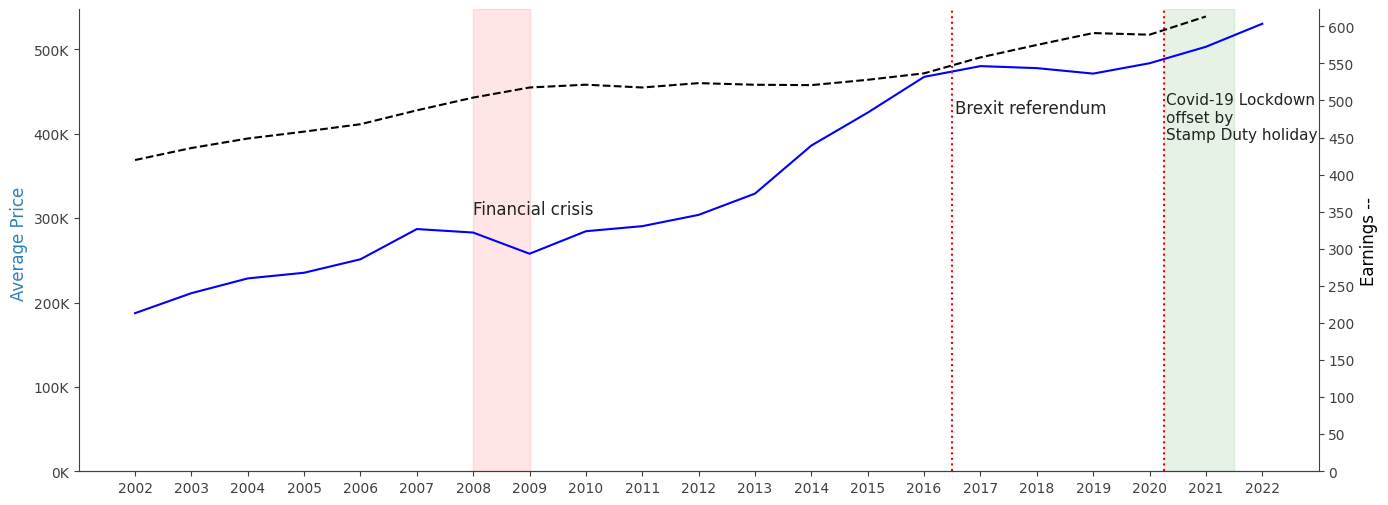

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))

# AVERAGE PRICE
area_data = regions_price[(regions_price['area']=='London') & (regions_price['year']>2001)]
ax.plot(area_data['year'], area_data['average_price'], label=area, color='blue')

# set title and axis label
# ax.set_title('Average Price & Interest Rate over time', fontsize = 16)
# ax.set_xlabel('Year', fontsize = 12, color = light_grey)
ax.set_ylabel('Average Price ', fontsize = 12, color = richest_color)

# Set axis colors
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)
ax.spines[['right','top']].set_visible(False)

# set x ticks every 1 year
ax.set_xticks(range(2002, 2023, 1))

# set y ticks
ax.set_yticks(range(0, 600000, 100000))

# Set tick colors
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# set formatter function to y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousand_formatter))

# Add events
ax.axvspan(2008,2009, alpha=0.1, color=decrease_color)
ax.text(2008, 300000, 'Financial crisis', ha='left', va='bottom', fontsize=12, color=dark_grey)
ax.axvline(2016.5, color=decrease_color, linestyle=':')
ax.text(2016.55, 420000, 'Brexit referendum', ha='left', va='bottom', fontsize=12, color=dark_grey)
ax.axvline(2020.25, color=decrease_color, linestyle=':')
ax.axvspan(2020.25,2021.5, alpha=0.1, color=increase_color)
ax.text(2020.3, 390000, 'Covid-19 Lockdown\noffset by\nStamp Duty holiday', ha='left', va='bottom', fontsize=11, color=dark_grey)

# # Earnings
# Plot the earnings
x= tmp['year']
ax2 = ax.twinx()
ax2.plot(tmp.year, tmp.earnings, label='Earnings', color = 'black',linestyle='dashed')

# # set axis label
ax2.set_ylabel('Earnings --', fontsize = 12, color = 'black')
# # Set tick colors
ax2.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax2.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# set y ticks
ax2.set_yticks(range(0, 650, 50))

# Set axis colors
ax2.spines['bottom'].set_edgecolor(light_grey)
ax2.spines['right'].set_edgecolor(light_grey)
ax2.spines[['left','top']].set_visible(False)
 
plt.show()

Before crisis

In [ ]:
# price variation before financial crisis
a = regions_price[(regions_price.area=='London')&(regions_price.year==2002)].average_price.values[0]
b = regions_price[(regions_price.area=='London')&(regions_price.year==2008)].average_price.values[0]
print(f'Price variation bf2008 : {round((b/a-1)*100)}%')

Price variation bf2008 : 51%


In [ ]:
# earnings variation before financial crisis
a = tmp[tmp.year==2002].earnings.values[0]
b = tmp[tmp.year==2008].earnings.values[0]
print(f'Earnings variation bf2008 : {round((b/a-1)*100)}%')

Earnings variation bf2008 : 20%


In [ ]:
# create the dataframe
data = {'variation': ['50%', '20%']}
index = ['house price', 'earnings']
df = pd.DataFrame(data=data, index=index)
df

,variation
house price,50%
earnings,20%


CPI 2002 : 74.5

CPI 2008 : 84.7

variation : 14%

btw crisis and brexit referendum

In [ ]:
# price variation fr financial crisis until Brexit referendum
a = regions_price[(regions_price.area=='London')&(regions_price.year==2009)].average_price.values[0]
b = regions_price[(regions_price.area=='London')&(regions_price.year==2016)].average_price.values[0]
print(f'Price variation between financial crisis and Brexit referendum : {round((b/a-1)*100)}%')

Price variation between financial crisis and Brexit referendum : 81%


In [ ]:
# earnings variation fr financial crisis until Brexit referendum
a = tmp[tmp.year==2009].earnings.values[0]
b = tmp[tmp.year==2016].earnings.values[0]
print(f'Earnings variation between financial crisis and Brexit referendum : {round((b/a-1)*100)}%')

Earnings variation between financial crisis and Brexit referendum : 4%


In [ ]:
# create the dataframe
data = {'variation': ['80%', '4%']}
index = ['house price', 'earnings']
df = pd.DataFrame(data=data, index=index)
df

,variation
house price,80%
earnings,4%


CPI 2009 : 86.6

CPI 2016 : 100.7

variation : 16%

from brexit referendum until 2022

In [ ]:
# price variation
a = regions_price[(regions_price.area=='London')&(regions_price.year==2016)].average_price.values[0]
b = regions_price[(regions_price.area=='London')&(regions_price.year==2021)].average_price.values[0]
print(f'Price variation  : {round((b/a-1)*100)}%')

Price variation  : 8%


In [ ]:
# earnings variation 
a = tmp[tmp.year==2016].earnings.values[0]
b = tmp[tmp.year==2021].earnings.values[0]
print(f'Earnings variation : {round((b/a-1)*100)}%')

Earnings variation : 14%


In [ ]:
# create the dataframe
data = {'variation': ['8%', '14%']}
index = ['house price', 'earnings']
df = pd.DataFrame(data=data, index=index)
df

,variation
house price,8%
earnings,14%


CPI 2016 : 100.7
CPI 2021 : 111.6
variation : 11%

# EDA Map - Average price per area 

The chart below shows that the most expensive areas are in West London, from  Richmond-upon-Thames to Westminster, those are areas surrounding the Thames river.

Prices decrease when the distance to those areas increase

Efforts have been made since decades to revitalise East London, with the creation of the new financial market in Canary Wharf and the construction of Elizabeth park to prepare Olympic 2012

The pandemic which favorised hybrid working has create a negative impact on the commute to office in East London and incertainties on the future of those areas

In [ ]:
tmp = london_y[london_y.year == 2022][['area','average_price']]

In [ ]:
geodata = geo.merge(tmp, how = 'inner', left_on = 'neighbourhood', right_on = 'area')[['area','geometry','average_price']]

In [ ]:
geodata['coords'] = geodata['geometry'].apply(lambda x: x.centroid.coords[:])
geodata['coords'] = [coords[0] for coords in geodata['coords']]

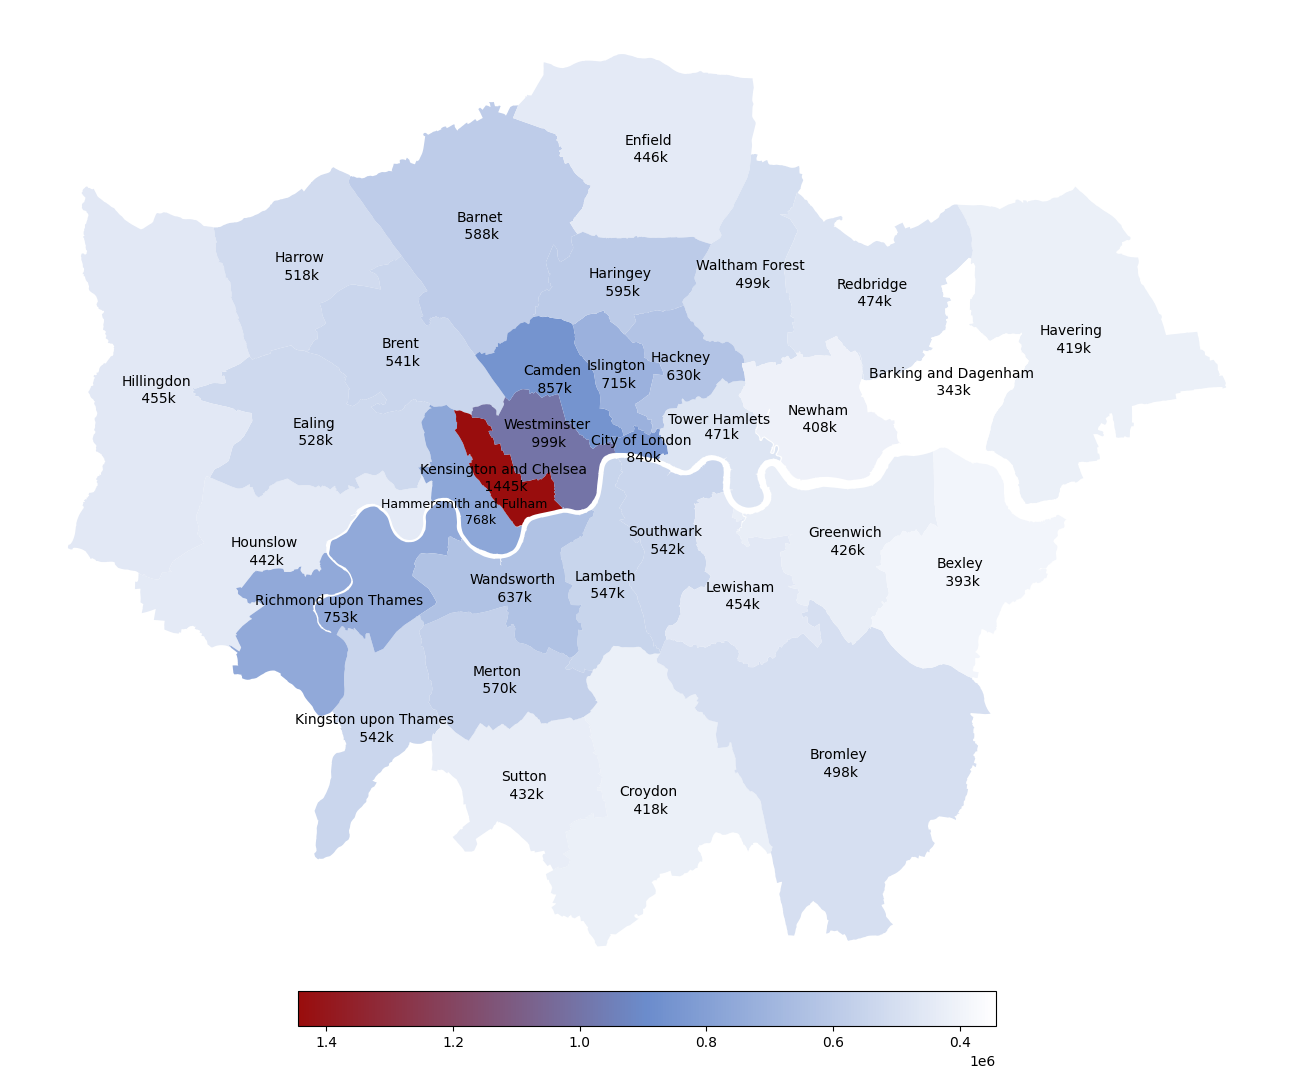

In [ ]:
fig,ax = plt.subplots(figsize=(30,15))

geodata.plot(column = geodata['average_price'],
             cmap = my_cmap,
             ax=ax,
             missing_kwds={"color": dark_grey})


# create a ScalarMappable object from the colormap
sm = plt.cm.ScalarMappable(cmap=my_cmap)
sm.set_array(geodata['average_price'])

# add a color bar
cbar = fig.colorbar(sm, ax=ax,orientation='horizontal',shrink=0.3, pad = 0.0001)
cbar.ax.invert_xaxis()

for idx, row in geodata.iterrows():
  hue = round(row['average_price']/1000)
  if row['area'] == 'Hammersmith and Fulham':
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1]-0.01,
            horizontalalignment='center', fontdict = { 'size': 9})
    
    plt.text(s=' ' + f'{hue}' +'k', x=row['coords'][0]+0.01,y = row['coords'][1] - 0.017 ,
            horizontalalignment='center', fontdict = {'size': 9})
    
  elif row['area'] == 'Tower Hamlets':
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1]+0.007,
            horizontalalignment='center', fontdict = {'size': 10})
    
    plt.text(s=' ' + f'{hue}' +'k', x=row['coords'][0],y = row['coords'][1] ,
            horizontalalignment='center', fontdict = {'size': 10})
    
  elif row['area'] == 'Westminster':
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1]+0.008,
            horizontalalignment='center', fontdict = {'size': 10})
    
    plt.text(s=' ' + f'{hue}' +'k', x=row['coords'][0],y = row['coords'][1] ,
            horizontalalignment='center', fontdict = {'size': 10})

  else:
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1],
            horizontalalignment='center', fontdict = {'size': 10})
    
    plt.text(s=' ' + f'{hue}' +'k', x=row['coords'][0],y = row['coords'][1] - 0.008 ,
            horizontalalignment='center', fontdict = {'size': 10})    

ax.axis('off')

plt.show()

# EDA House price and index between the most and least expensive boroughs

The below charts shows a clear distinction between the top 3 most and least expensive areas.

In 1995, the average price in Kensington is 3.7 times of one in Barking. This figure is now 4.2 times, which means that the gap between the most expensive borough of Kensington and Chelsea and the least expensive borough of Barking and Dagenham has been widened.

On the bright side, in terms of House price index, the least expensive area has outperformed the most expensive one

In [ ]:
top_3_richest = london_y[london_y.year == 2022].sort_values('average_price')['area'].tail(3).to_list()
top_3_poorest = london_y[london_y.year == 2022].sort_values('average_price')['area'].head(3).to_list()

Average price over time

In [ ]:
import matplotlib.patches as mpatches


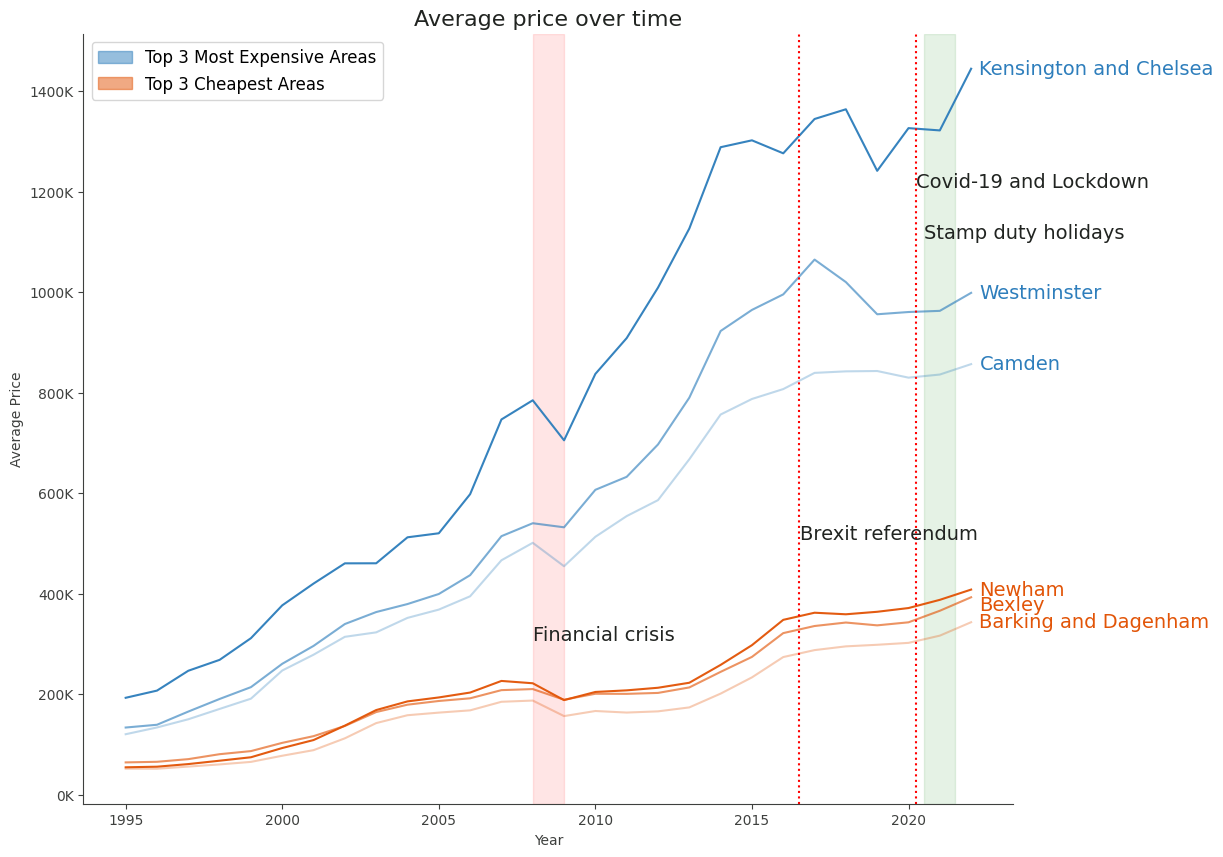

In [ ]:
# line chart for each borough over time
unique_areas = top_3_richest + top_3_poorest

fig, ax = plt.subplots(figsize=(12,10))

for i, area in enumerate(unique_areas):
    area_data = london_y[london_y['area']==area]
    if i < 3:
        # richest areas
        color = richest_color
        alpha = i / 3 + 0.3  # set alpha to make colors lighter or darker
    else:
        # poorest areas
        color = poorest_color
        alpha = (i-3) / 3 + 0.3  # set alpha to make colors lighter or darker
    ax.plot(area_data['year'], area_data['average_price'], label=area, color=color, alpha=alpha)

# add legend on lines
for line in ax.lines:
    label = line.get_label()
    if label == 'Bexley':
        ax.annotate(label, xy=(london_y['year'].max(), line.get_ydata()[-1]-15000), xytext=(6,0), fontsize = 14, color=line.get_color(), textcoords="offset points", va="center")
    else:
        ax.annotate(label, xy=(london_y['year'].max(), line.get_ydata()[-1]), xytext=(6,0), fontsize = 14, color=line.get_color(), textcoords="offset points", va="center")

# set title and labels
ax.set_title('Average price over time', fontsize = 16,color=dark_grey)
ax.set_xlabel('Year',color=light_grey)
ax.set_ylabel('Average Price',color=light_grey)

# set axis colors
ax.spines[['right','top']].set_visible(False)
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)

# set formatter function to y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousand_formatter))

# add legends
richest_patch = mpatches.Patch(color=richest_color, alpha=0.5, label='Top 3 Most Expensive Areas')
poorest_patch = mpatches.Patch(color=poorest_color, alpha=0.5, label='Top 3 Cheapest Areas')
ax.legend(handles=[richest_patch, poorest_patch], fontsize=12, loc='upper left')

# Set tick colors
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# Add events
ax.axvspan(2008,2009, alpha=0.1, color=decrease_color)
ax.text(2008, 300000, 'Financial crisis', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvline(x=2016.5, color=decrease_color, linestyle=':')
ax.text(2016.55, 500000, 'Brexit referendum', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvline(x=2020.25, color=decrease_color, linestyle=':')
ax.text(2020.25, 1200000, 'Covid-19 and Lockdown', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvspan(2020.5,2021.5, alpha=0.1, color=increase_color)
ax.text(2020.5, 1100000, 'Stamp duty holidays', ha='left', va='bottom', fontsize=14, color=dark_grey)

plt.show()


House index over time

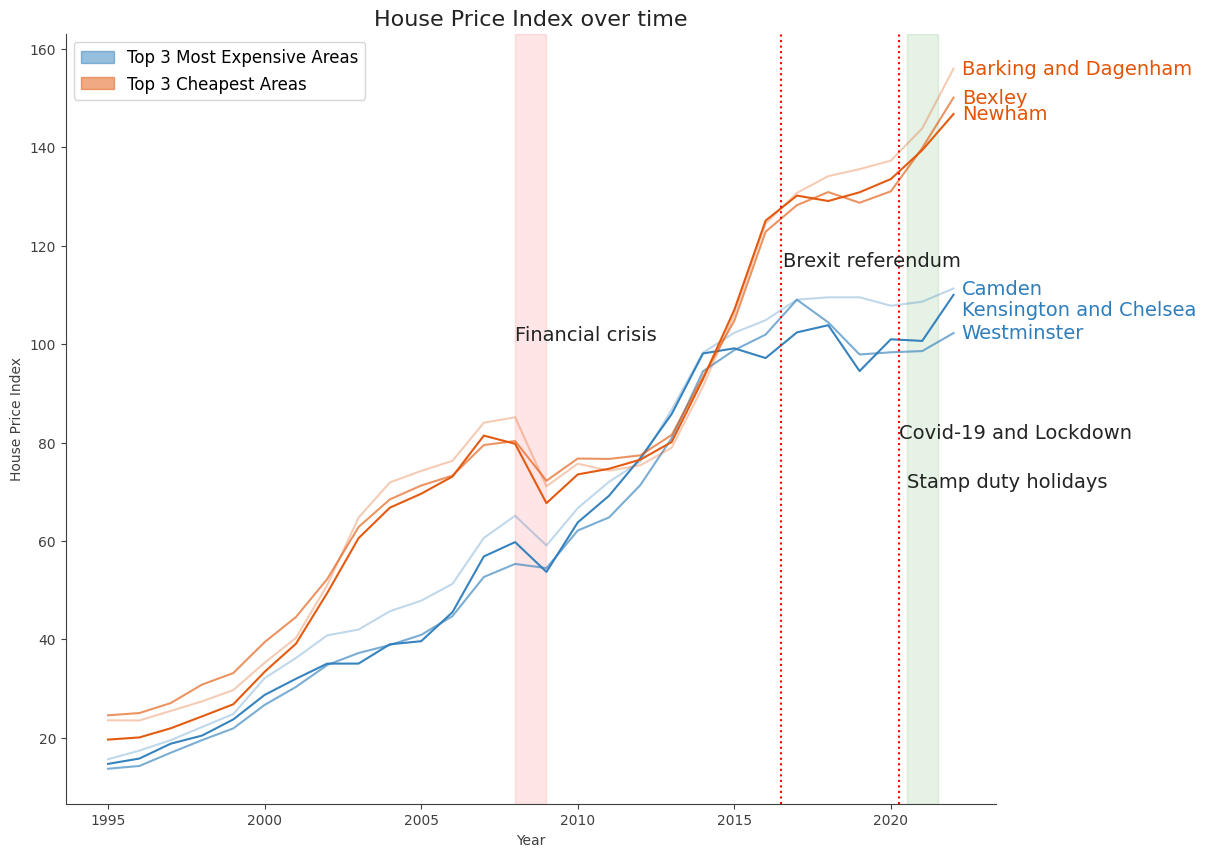

In [ ]:
# line chart for each borough over time
unique_areas = top_3_richest + top_3_poorest

fig, ax = plt.subplots(figsize=(12,10))

for i, area in enumerate(unique_areas):
    area_data = london_y[london_y['area']==area]
    if i < 3:
        # richest areas
        color = richest_color
        alpha = i / 3 + 0.3  # set alpha to make colors lighter or darker
    else:
        # poorest areas
        color = poorest_color
        alpha = (i-3) / 3 + 0.3  # set alpha to make colors lighter or darker
    ax.plot(area_data['year'], area_data['house_index'], label=area, color=color, alpha=alpha)

# add legend on lines
for line in ax.lines:
    label = line.get_label()
    if label == 'Kensington and Chelsea':
        ax.annotate(label, xy=(london_y['year'].max(), line.get_ydata()[-1]-3), xytext=(6,0), fontsize = 14, color=line.get_color(), textcoords="offset points", va="center")
    else:
        ax.annotate(label, xy=(london_y['year'].max(), line.get_ydata()[-1]), xytext=(6,0), fontsize = 14, color=line.get_color(), textcoords="offset points", va="center")

# set title and label
ax.set_title('House Price Index over time', fontsize = 16, color = dark_grey)
ax.set_xlabel('Year',color=light_grey)
ax.set_ylabel('House Price Index',color=light_grey)


# add legends
richest_patch = mpatches.Patch(color=richest_color, alpha=0.5, label='Top 3 Most Expensive Areas')
poorest_patch = mpatches.Patch(color=poorest_color, alpha=0.5, label='Top 3 Cheapest Areas')
ax.legend(handles=[richest_patch, poorest_patch], fontsize=12, loc='upper left')

# Set tick colors
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# set axis colors
ax.spines[['right','top']].set_visible(False)
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)

# Add events
ax.axvspan(2008,2009, alpha=0.1, color=decrease_color)
ax.text(2008, 100, 'Financial crisis', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvline(x=2016.5, color=decrease_color, linestyle=':')
ax.text(2016.55, 115, 'Brexit referendum', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvline(x=2020.25, color=decrease_color, linestyle=':')
ax.text(2020.25, 80, 'Covid-19 and Lockdown', ha='left', va='bottom', fontsize=14, color=dark_grey)
ax.axvspan(2020.5,2021.5, alpha=0.1, color=increase_color)
ax.text(2020.5, 70, 'Stamp duty holidays', ha='left', va='bottom', fontsize=14, color=dark_grey)

plt.show()


In [ ]:
london_y[(london_y.year == 1995) & (london_y.area.isin(['Kensington and Chelsea','Barking and Dagenham']))][['year','area','average_price','house_index']]

,year,area,average_price,house_index
0,1995,Barking and Dagenham,51818.00000,23.53333
19,1995,Kensington and Chelsea,192857.25000,14.68333


In [ ]:
london_y[(london_y.year == 2022) & (london_y.area.isin(['Kensington and Chelsea','Barking and Dagenham']))][['year','area','average_price','house_index']]

,year,area,average_price,house_index
891,2022,Barking and Dagenham,343260.36364,155.97273
910,2022,Kensington and Chelsea,1444576.63636,110.00909


In [ ]:
a = 193/52
print(f'in 1995, average house price in Kensington and Chelsea is {a:.2f} times more expensive than in Barking and Dagenham')

in 1995, average house price in Kensington and Chelsea is 3.71 times more expensive than in Barking and Dagenham


In [ ]:
a = 1445/343
print(f'in 2022, average house price in Kensington and Chelsea is {a:.2f} times more expensive than in Barking and Dagenham')

in 2022, average house price in Kensington and Chelsea is 4.21 times more expensive than in Barking and Dagenham


# EDA Sales Volume vs Population over time

The population has increased steadily over time, in spite of economic, social and political events.

The sales volume on the other hand has decreased and the price has been increased.

It means that the markets has moved toward more rentals and less homeownership.

London housing markets has more investors and homeowners. This demonstrates once again the struggling situation of young people to get into the property ladder

In [ ]:
sales_df = london_y.groupby('year')['volume'].mean().reset_index()
sales_df['rolling_average'] = sales_df['volume'].rolling(window=3, min_periods=1).mean().reset_index(drop=True)
sales_df = sales_df[-(sales_df.year.isin([1995,1996]))]

In [ ]:
population_df = london_y.groupby('year')['total_population'].sum().reset_index()
population_df = population_df[(population_df.year>1998)&(population_df.year<2021)]

In [ ]:
sales_vs_population = sales_df.merge(population_df, on='year',how='inner')

In [ ]:
sales_vs_population['sales_index'] = (sales_vs_population.volume/5123.152)*100
sales_vs_population['sales_index'] = sales_vs_population.sales_index.astype(int)

In [ ]:
sales_vs_population['population_index'] = (sales_vs_population.total_population/7153912)*100
sales_vs_population['population_index'] = sales_vs_population['population_index'].astype(int)

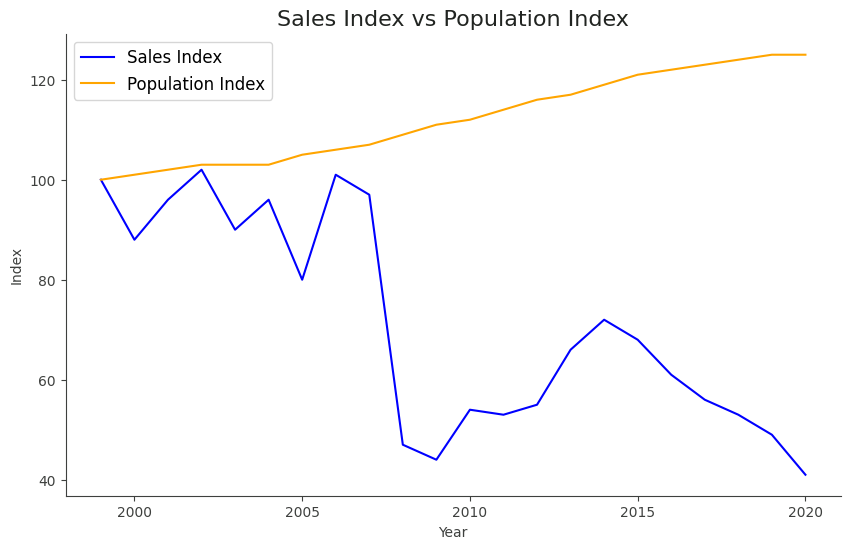

In [ ]:
# Set colors for the two line plots
sales_color = 'blue'
population_color = 'orange'

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the two line plots for 'sales_index' and 'population_index' columns
ax.plot(sales_vs_population['year'], sales_vs_population['sales_index'], color=sales_color, label='Sales Index')
ax.plot(sales_vs_population['year'], sales_vs_population['population_index'], color=population_color, label='Population Index')

# Add legend to the plot
ax.legend(fontsize=12, loc='upper left')

# Set the title and labels for the plot
ax.set_title('Sales Index vs Population Index', fontsize=16,color=dark_grey)
ax.set_xlabel('Year',color=light_grey)
ax.set_ylabel('Index',color=light_grey)

# Set the y-axis formatter function
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)

# Set tick colors
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# Show the plot
plt.show()


Population increases, Sales Volumes decreases and Price keep increasing -> People rent rather than buy
More investors, Less homeowners
London real estate less and less affordable
Young people struggle to get into the property ladder
-> Need policy to help people buying their first home

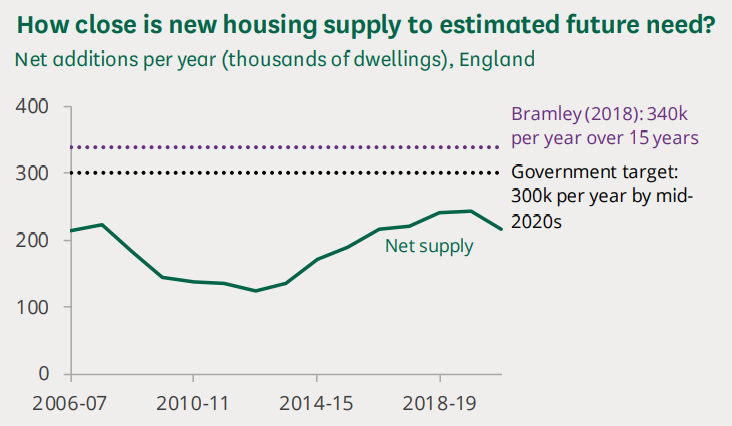

Parliament document on research on housing need
https://researchbriefings.files.parliament.uk/documents/CBP-7671/CBP-7671.pdf

Housing supply is an issue that is rarely out of the media – an ageing population, immigration and a growing number of one-person households are all creating a need for more housing. Rising prices have also raised questions about how to provide housing that’s affordable for everyone.

Interactive dashboard on housing supply per borough overtime
https://commonslibrary.parliament.uk/local-authority-data-housing-supply/

# EDA Demographics of the richest and poorest area in London

The chart belows shows that while the dominate age group of Barking is youth, the dominant one is Kensington is Mid-career people. 

Also the senior group in Kensington represent a much higher proporton of the population than in Barking.

Barking has a younger demographics, while the life expentancy in Kensington is higher.

Barking's typical household is young family with children, while the Kensington typical household is couple in early or mid-career



In [ ]:
test1 = london_y[(london_y.year == 2019) & (london_y.area.isin(['Kensington and Chelsea','Barking and Dagenham']))][['area','youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population']]

In [ ]:
test1['youth_male_proportion'] = test1['youth_male'] / test1['total_population']
test1['youth_female_proportion'] = test1['youth_female'] / test1['total_population']
test1['working_age_male_proportion'] = test1['working_age_male'] / test1['total_population']
test1['working_age_female_proportion'] = test1['working_age_female'] / test1['total_population']
test1['mid_career_male_proportion'] = test1['mid_career_male'] / test1['total_population']
test1['mid_career_female_proportion'] = test1['mid_career_female'] / test1['total_population']
test1['senior_male_proportion'] = test1['senior_male'] / test1['total_population']
test1['senior_female_proportion'] = test1['senior_female'] / test1['total_population']


In [ ]:
test1

,area,youth_male,youth_female,working_age_male,working_age_female,mid_career_male,mid_career_female,senior_male,senior_female,total_population,youth_male_proportion,youth_female_proportion,working_age_male_proportion,working_age_female_proportion,mid_career_male_proportion,mid_career_female_proportion,senior_male_proportion,senior_female_proportion
792,Barking and Dagenham,33908.00000,36697.00000,32564.00000,32585.00000,30716.00000,29250.00000,9841.00000,7345.00000,212906.00000,0.15926,0.17236,0.15295,0.15305,0.14427,0.13738,0.04622,0.03450
811,Kensington and Chelsea,16181.00000,17160.00000,22888.00000,24796.00000,27004.00000,25834.00000,12179.00000,10087.00000,156129.00000,0.10364,0.10991,0.14660,0.15882,0.17296,0.16547,0.07801,0.06461


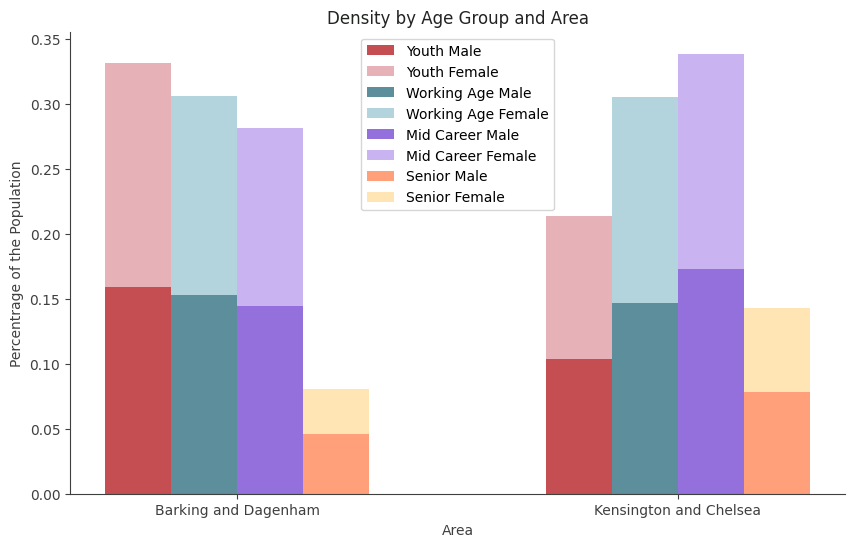

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(test1['area']))
labels = test1['area']

youth_male = test1['youth_male_proportion']
youth_female = test1['youth_female_proportion']
working_age_male = test1['working_age_male_proportion']
working_age_female = test1['working_age_female_proportion']
mid_career_male = test1['mid_career_male_proportion']
mid_career_female = test1['mid_career_female_proportion']
senior_male = test1['senior_male_proportion']
senior_female = test1['senior_female_proportion']

width = 0.15

# Define the color schemes for each age group
youth_color = ['#C44E52', '#E6B2B8']
working_age_color = ['#5D8E9B', '#B4D4DD']
mid_career_color = ['#9370DB', '#C9B3F1']
senior_color = ['#FFA07A', '#FFE5B4']

# Plot the bars for each age group
ax.bar(x - 3*width/2, youth_male, width, color=youth_color[0], label='Youth Male')
ax.bar(x - 3*width/2, youth_female, width, bottom=youth_male, color=youth_color[1], label='Youth Female')

ax.bar(x - width/2, working_age_male, width, color=working_age_color[0], label='Working Age Male')
ax.bar(x - width/2, working_age_female, width, bottom=working_age_male, color=working_age_color[1], label='Working Age Female')

ax.bar(x + width/2, mid_career_male, width, color=mid_career_color[0], label='Mid Career Male')
ax.bar(x + width/2, mid_career_female, width, bottom=mid_career_male, color=mid_career_color[1], label='Mid Career Female')

ax.bar(x + 3*width/2, senior_male, width, color=senior_color[0], label='Senior Male')
ax.bar(x + 3*width/2, senior_female, width, bottom=senior_male, color=senior_color[1], label='Senior Female')

# set title, labels and legends
ax.set_title('Density by Age Group and Area',color=dark_grey)
ax.set_xlabel('Area',color=light_grey)
ax.set_ylabel('Percentrage of the Population',color=light_grey)
ax.legend()

# Set tick colors
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', color=light_grey, labelcolor=light_grey)
ax.tick_params(axis='y', color=light_grey, labelcolor=light_grey)

# set axis colors
ax.spines[['right','top']].set_visible(False)
ax.spines['bottom'].set_edgecolor(light_grey)
ax.spines['left'].set_edgecolor(light_grey)

plt.show()


# EDA pay gap

The pay gap map doesn't show a clear pattern, as opposed to the house average price map above. It means that the pay gap is independent to the wealth gap.

Local councils need to investigate further into their own particularities to find appropriate solutions

In [ ]:
london_y['pay_gap'] = (1 - london_y.female_earnings/london_y.male_earnings)*100

In [ ]:
tmp = london_y[london_y.year == 2021][['area','pay_gap']]

In [ ]:
geodata = geo.merge(tmp, how = 'inner', left_on = 'neighbourhood', right_on = 'area')[['area','geometry','pay_gap']]

In [ ]:
geodata['coords'] = geodata['geometry'].apply(lambda x: x.centroid.coords[:])
geodata['coords'] = [coords[0] for coords in geodata['coords']]

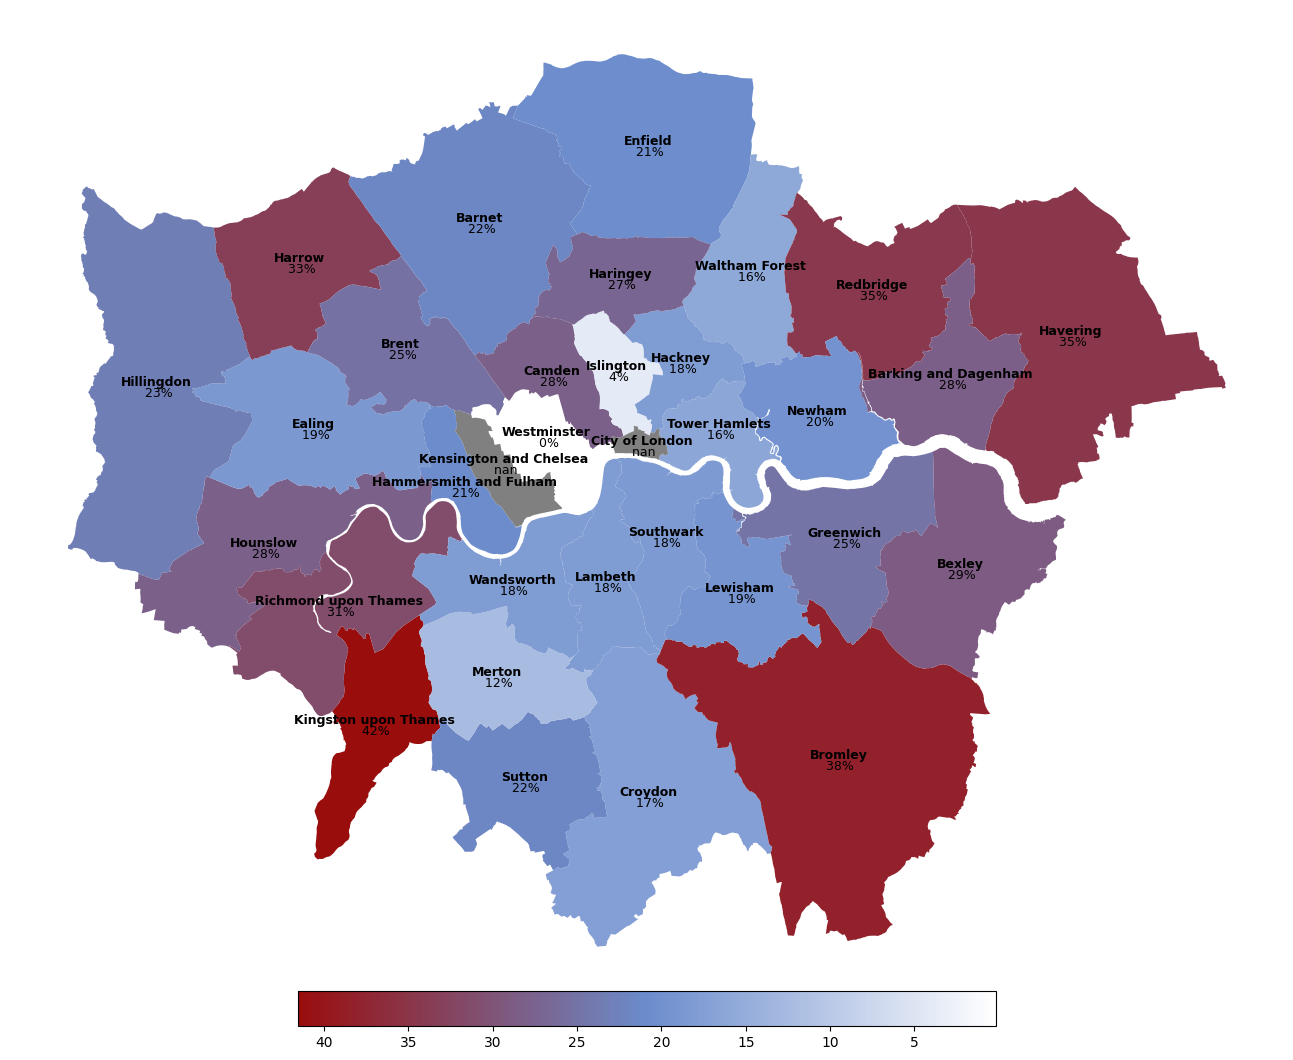

In [ ]:
fig,ax = plt.subplots(figsize=(30,15))

geodata.plot(column = geodata['pay_gap'],
             cmap = my_cmap,
             ax=ax,
             missing_kwds={"color": "gray"})


# create a ScalarMappable object from the colormap
sm = plt.cm.ScalarMappable(cmap=my_cmap)
sm.set_array(geodata['pay_gap'])

# add a color bar
cbar = fig.colorbar(sm, ax=ax,orientation='horizontal',shrink=0.3, pad = 0.0001)
cbar.ax.invert_xaxis()

for idx, row in geodata.iterrows():
  if row['area'] == 'Kensington and Chelsea':
    hue = round(row['pay_gap'],0)
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1]+0.005,
            horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 9})
    
    plt.text(s=' ' + f'{hue}', x=row['coords'][0],y = row['coords'][1],
            horizontalalignment='center', fontdict = {'size': 9}) 

  elif row['area'] == 'City of London':
    hue = round(row['pay_gap'],0)
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1],
            horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 9})

    plt.text(s=' ' + f'{hue}', x=row['coords'][0],y = row['coords'][1] - 0.005,
            horizontalalignment='center', fontdict = {'size': 9}) 

  elif row['area'] == 'Tower Hamlets' or row['area'] == 'Westminster':
    hue = round(row['pay_gap'])
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1]+0.005,
            horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 9})
    
    plt.text(s=' ' + f'{hue}' +'%', x=row['coords'][0],y = row['coords'][1],
            horizontalalignment='center', fontdict = {'size': 9}) 

  else:
    hue = round(row['pay_gap'])
    plt.text(s=row['area'], x = row['coords'][0], y = row['coords'][1],
            horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 9})
    
    plt.text(s=' ' + f'{hue}' +'%', x=row['coords'][0],y = row['coords'][1] - 0.005 ,
            horizontalalignment='center', fontdict = {'size': 9})    

ax.axis('off')

plt.show()

# EDA Correlation



The housing price is positively correlated to:

- Earnings, especially Female earnings

- Dwelling density

- Job number and density

- Recycling rate

- Crime number

- Well being

And negatively correlated to:

- Volume

- Youth population


In [ ]:
corr = london_y.corr()

<ipython-input-190-7b7cf42c0cfa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = london_y.corr()


In [ ]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

<ipython-input-191-762ef94df992>:15: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis=1)\


,year,average_price,volume,house_index,earnings,male_earnings,female_earnings,recycling_rate,jobs_number,jobs_density,dwellings_number,surface_in_ha,dwellings_density,youth_male,youth_female,working_age_male,working_age_female,mid_career_male,mid_career_female,senior_male,senior_female,total_population,anxiety,happiness,life_satisfaction,worthwhile,crime_number,pay_gap
year,1.00,0.73,-0.45,0.97,0.57,0.49,0.59,0.72,0.14,0.04,0.17,-0.00,0.09,0.22,0.24,0.15,0.17,0.34,0.39,0.10,0.25,0.27,-0.27,0.54,0.57,0.49,0.16,-0.18
average_price,0.73,1.00,-0.42,0.65,0.80,0.72,0.80,0.36,0.49,0.21,-0.05,-0.33,0.54,-0.27,-0.25,-0.05,-0.02,-0.06,-0.03,-0.18,-0.07,-0.12,0.14,0.11,0.26,0.08,0.31,-0.20
volume,-0.45,-0.42,1.00,-0.37,-0.32,-0.21,-0.33,-0.37,-0.18,-0.36,0.51,0.40,-0.15,0.33,0.31,0.40,0.33,0.32,0.29,0.44,0.35,0.39,-0.05,-0.02,-0.08,0.03,0.03,0.16
house_index,0.97,0.65,-0.37,1.00,0.38,0.35,0.38,0.68,0.01,-0.04,0.21,0.14,-0.08,0.32,0.34,0.14,0.16,0.42,0.46,0.22,0.34,0.33,-0.40,0.55,0.57,0.55,0.04,-0.08
earnings,0.57,0.80,-0.32,0.38,1.00,0.93,0.93,0.34,0.44,0.26,-0.02,-0.25,0.48,-0.40,-0.40,-0.02,-0.05,-0.13,-0.09,-0.17,-0.10,-0.19,0.28,0.11,0.28,0.09,0.19,-0.08
male_earnings,0.49,0.72,-0.21,0.35,0.93,1.00,0.78,0.39,0.36,0.41,-0.00,-0.07,0.32,-0.38,-0.38,-0.11,-0.15,-0.04,-0.02,0.00,0.05,-0.18,0.18,0.19,0.34,0.19,0.08,0.25
female_earnings,0.59,0.80,-0.33,0.38,0.93,0.78,1.00,0.26,0.48,0.21,0.07,-0.37,0.59,-0.32,-0.32,0.16,0.14,-0.12,-0.08,-0.26,-0.17,-0.10,0.33,0.00,0.15,-0.05,0.33,-0.40
recycling_rate,0.72,0.36,-0.37,0.68,0.34,0.39,0.26,1.00,-0.06,0.00,0.08,0.29,-0.27,0.15,0.17,-0.05,-0.09,0.38,0.39,0.29,0.39,0.18,-0.16,0.19,0.17,0.23,-0.48,0.17
jobs_number,0.14,0.49,-0.18,0.01,0.44,0.36,0.48,-0.06,1.00,0.48,-0.08,-0.28,0.37,-0.32,-0.32,-0.03,0.02,-0.25,-0.20,-0.27,-0.21,-0.20,0.18,-0.06,0.06,-0.11,0.77,-0.18
jobs_density,0.04,0.21,-0.36,-0.04,0.26,0.41,0.21,0.00,0.48,1.00,-0.60,-0.25,-0.08,-0.54,-0.53,-0.51,-0.48,-0.52,-0.52,-0.44,-0.44,-0.58,0.21,-0.06,0.11,0.09,0.64,-0.09


**Target Correlation**

House price is postively correlated to:
*   earnings
*   recycling rate
*   job number & density
*   population, espiecially mid career woman population
*   dwellings density
*   happiness, life satisfaction, worthwhile index
*   crime numbers (surprinsingly)

House price is negatively correlated to:
*   sales volume
*   anxiety index


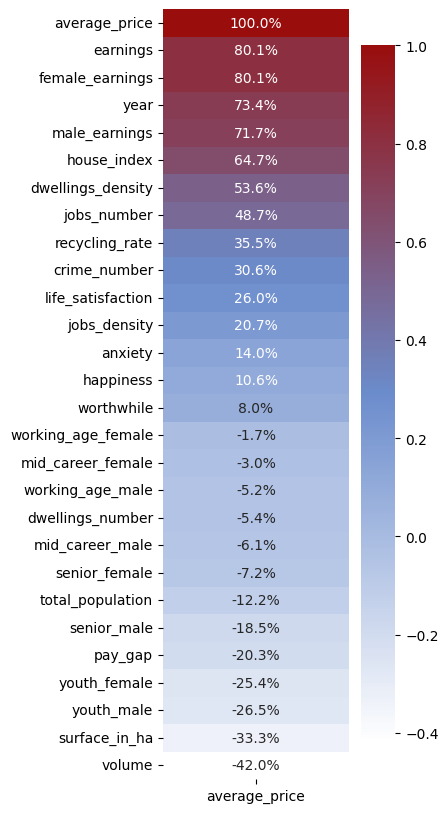

In [ ]:
target = 'average_price'

plt.figure(figsize=(3,10))
sns.heatmap(corr[[target]].sort_values(by=[target],ascending=False),
            annot=True,
            fmt=".1%",
            cmap = my_cmap);

# ML - Linear regression on multiple variables - normalised data

The correlation table is almost aligned to the results of Linear Regression

In [ ]:
df = london_y[['year', 'average_price', 'volume', 'earnings', 'male_earnings',
       'female_earnings', 'recycling_rate', 'jobs_number', 'jobs_density',
       'dwellings_number', 'surface_in_ha', 'dwellings_density', 'youth_male',
       'youth_female', 'working_age_male', 'working_age_female',
       'mid_career_male', 'mid_career_female', 'senior_male', 'senior_female',
       'total_population']]

# df = london_y[['average_price', 'volume', 'house_index', 'earnings',
#        'male_earnings', 'female_earnings', 'recycling_rate', 'jobs_number',
#        'jobs_density', 'dwellings_number', 'surface_in_ha',
#        'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
#        'working_age_female', 'mid_career_male', 'mid_career_female',
#        'senior_male', 'senior_female', 'total_population', 'anxiety',
#        'happiness', 'life_satisfaction', 'worthwhile', 'crime_number',
#        'pay_gap']]

# drop rows with NaN values
df = df.dropna()

In [ ]:
df.columns

Index(['year', 'average_price', 'volume', 'earnings', 'male_earnings',
       'female_earnings', 'recycling_rate', 'jobs_number', 'jobs_density',
       'dwellings_number', 'surface_in_ha', 'dwellings_density', 'youth_male',
       'youth_female', 'working_age_male', 'working_age_female',
       'mid_career_male', 'mid_career_female', 'senior_male', 'senior_female',
       'total_population'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 231 to 824
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                570 non-null    int64  
 1   average_price       570 non-null    float64
 2   volume              570 non-null    float64
 3   earnings            570 non-null    float64
 4   male_earnings       570 non-null    float64
 5   female_earnings     570 non-null    float64
 6   recycling_rate      570 non-null    float64
 7   jobs_number         570 non-null    float64
 8   jobs_density        570 non-null    float64
 9   dwellings_number    570 non-null    float64
 10  surface_in_ha       570 non-null    float64
 11  dwellings_density   570 non-null    float64
 12  youth_male          570 non-null    float64
 13  youth_female        570 non-null    float64
 14  working_age_male    570 non-null    float64
 15  working_age_female  570 non-null    float64
 16  mid_ca

In [ ]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
scaler = StandardScaler()

# normalize the data
df_norm = scaler.fit_transform(df)

# convert the normalized data back to a DataFrame
df_norm = pd.DataFrame(df_norm, columns=df.columns)

# separate the target variable
y = df_norm['average_price']
X = df_norm.drop('average_price', axis=1)

In [ ]:
# split the data into train and test sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(df_norm):
    # print(train_index,test_index)
    train = df_norm.loc[train_index]
    test = df_norm.loc[test_index]
    
# separate the target and features in the train and test sets
X_train = train[['volume', 'earnings', 'male_earnings', 'female_earnings', 'recycling_rate',
       'jobs_number', 'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population']].values
y_train = train['average_price'].values
X_test = test[['volume', 'earnings', 'male_earnings', 'female_earnings', 'recycling_rate',
       'jobs_number', 'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population']].values
y_test = test['average_price'].values


In [ ]:
# build and train model
lg = LinearRegression()
lg.fit(X_train, y_train)

print(f"Coef: {lg.coef_}")
print(f"Intercept: {lg.intercept_}")

# test model
y_pred = lg.predict(X_test)
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Coef: [ 0.05801328  0.30760693  0.05431758  0.15562826 -0.01061238 -0.75837459
  0.87132252 -0.30113676 -0.01153671  0.25558785 -0.45874492  0.48977311
 -0.22717306  0.3073948   0.99419513 -0.6428969  -0.24080592  0.24401508
  0.09500261]
Intercept: -0.20357001519322115
Mean Absolute Error: 0.6297297112140399
Mean Squared Error: 0.7510766594825865
Root Mean Squared Error: 0.8666467904992128


In [ ]:
# interpret model
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
model_stats = sm.OLS(y_train.reshape(-1, 1), X2).fit()
model_stats.summary(xname=['const', 'volume', 'earnings', 'male_earnings', 'female_earnings', 'recycling_rate',
       'jobs_number', 'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     86.28
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          1.11e-118
Time:                        17:02:35   Log-Likelihood:                -68.820
No. Observations:                 380   AIC:                             175.6
Df Residuals:                     361   BIC:                             250.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2036      0.020     -9.959      0.000      -0.244      -0.163
volume                 0.0580      0.023      2.470      0.014       0.012       0.104
earnings               0.3076      0.117      2.632      0.009       0.078       0.537
male_earnings          0.0543      0.067      0.808      0.420      -0.078       0.187
female_earnings        0.1556      0.071      2.193      0.029       0.016       0.295
recycling_rate        -0.0106      0.032     -0.335      0.738      -0.073       0.052
jobs_number           -0.7584      0.299     -2.533      0.012      -1.347      -0.170
jobs_density           0.8713      0.290      3.009      0.003       0.302       1.441
dwellings_number      -0.3011      0.109     -2.773      0.006      -0.515      -0.088
surface_in_ha         -0.0115      0.043     -0.270      0.788      -0.096       0.073
dwellings_density      0.2556      0.050      5.152      0.000       0.158       0.353
youth_male            -0.4587      0.229     -2.003      0.046      -0.909      -0.008
youth_female           0.4898      0.236      2.074      0.039       0.025       0.954
working_age_male      -0.2272      0.119     -1.903      0.058      -0.462       0.008
working_age_female     0.3074      0.106      2.899      0.004       0.099       0.516
mid_career_male        0.9942      0.223      4.448      0.000       0.555       1.434
mid_career_female     -0.6429      0.238     -2.697      0.007      -1.112      -0.174
senior_male           -0.2408      0.188     -1.278      0.202      -0.611       0.130
senior_female          0.2440      0.205      1.193      0.234      -0.158       0.646
total_population       0.0950      0.024      3.926      0.000       0.047       0.143
==============================================================================
Omnibus:                      261.702   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5770.865
Skew:                           2.546   Prob(JB):                         0.00
Kurtosis:                      21.400   Cond. No.                     1.26e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.8e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# df = london_y[['year', 'average_price', 'volume', 'earnings', 'male_earnings',
#        'female_earnings', 'recycling_rate', 'jobs_number', 'jobs_density',
#        'dwellings_number', 'surface_in_ha', 'dwellings_density', 'youth_male',
#        'youth_female', 'working_age_male', 'working_age_female',
#        'mid_career_male', 'mid_career_female', 'senior_male', 'senior_female',
#        'total_population']]

df = london_y[['average_price', 'volume', 'house_index', 'earnings',
       'male_earnings', 'female_earnings', 'recycling_rate', 'jobs_number',
       'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population', 'anxiety',
       'happiness', 'life_satisfaction', 'worthwhile', 'crime_number',
       'pay_gap']]

# drop rows with NaN values
df = df.dropna()

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
scaler = StandardScaler()

# normalize the data
df_norm = scaler.fit_transform(df)

# convert the normalized data back to a DataFrame
df_norm = pd.DataFrame(df_norm, columns=df.columns)

# separate the target variable
y = df_norm['average_price']
X = df_norm.drop('average_price', axis=1)

In [ ]:
# split the data into train and test sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(df_norm):
    # print(train_index,test_index)
    train = df_norm.loc[train_index]
    test = df_norm.loc[test_index]
    
# separate the target and features in the train and test sets
X_train = train[['volume', 'earnings', 'male_earnings', 'female_earnings', 'recycling_rate',
       'jobs_number', 'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population', 'anxiety', 'happiness', 'life_satisfaction',
       'worthwhile', 'crime_number', 'pay_gap']].values
y_train = train['average_price'].values
X_test = test[['volume', 'earnings', 'male_earnings', 'female_earnings', 'recycling_rate',
       'jobs_number', 'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population', 'anxiety', 'happiness', 'life_satisfaction',
       'worthwhile', 'crime_number', 'pay_gap']].values
y_test = test['average_price'].values


In [ ]:
# build and train model
lg = LinearRegression()
lg.fit(X_train, y_train)

print(f"Coef: {lg.coef_}")
print(f"Intercept: {lg.intercept_}")

# test model
y_pred = lg.predict(X_test)
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


In [ ]:
# interpret model
X2 = sm.add_constant(X_train)
model_stats = sm.OLS(y_train.reshape(-1, 1), X2).fit()
model_stats.summary(xname=['const', 'volume', 'earnings', 'male_earnings', 'female_earnings', 'recycling_rate',
       'jobs_number', 'jobs_density', 'dwellings_number', 'surface_in_ha',
       'dwellings_density', 'youth_male', 'youth_female', 'working_age_male',
       'working_age_female', 'mid_career_male', 'mid_career_female',
       'senior_male', 'senior_female', 'total_population', 'anxiety', 'happiness', 'life_satisfaction',
       'worthwhile', 'crime_number', 'pay_gap'])